# AI Clinique #15 : Recommender Systems

- __Date__: 09-12-2021
- __Presentator__: Nicolas Clavel
- __Datasets__: For this hands-on, we will be using the following open source datasets
    - Movie Lens Dataset accessible here: https://grouplens.org/datasets/movielens/latest/
    - The movie database: https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv
- __Packages__: pip install -r requirements.txt
- __Documentation__:
    - Interesting Github: https://github.com/rposhala/Recommender-System-on-MovieLens-dataset#content-based-recommender-system
    - Scikit-surprise: http://surprise.readthedocs.io/en/stable/getting_started.html
    - Matrix Factorization from scratch: https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b
    - Content-based filtering Kaggle: https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system/notebook
- __Citation__:  
Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems 

## Recommender Systems
The objective of a Recommender System is to __recommend relevant items for users__, based on their preference, history consumption...  
We see the use of recommendation systems all around us. These systems are personalizing our web experience, telling us what to buy (Amazon), which movies to watch (Netflix), whom to be friends with (Facebook), which songs to listen (Spotify) etc.  
Recommender systems typically produce a list of recommendations and there are few ways in which it can be done.  
Two of the most popular ways are – through __collaborative filtering__ or through __content-based filtering__

### Table of contents
- __1. Presentation of the Movie Lens dataset__
- __2. Collaborative filtering__
- __3. Content based filtering__
- __4. Simple recommender system__

#### Imports

In [207]:
import numpy as np
import pandas as pd
from surprise import SVD, NMF, KNNBasic, Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
import matplotlib
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel

## 1. Presentation of the Movie Lens dataset

#### Movies file

In [2]:
# Load movies
movies = pd.read_csv('../input_data/ml-latest-small/movies.csv', low_memory=False)

# Figures
print(f'Nb of rows in the movies file: {len(movies)}')
print(f'Columnsof the movies file: {movies.columns.values}')

# Print the first three rows
movies.head(3)

Nb of rows in the movies file: 9742
Columnsof the movies file: ['movieId' 'title' 'genres']


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


#### Ratings

In [9]:
# Load ratings
ratings = pd.read_csv('../input_data/ml-latest-small/ratings.csv', low_memory=False)


# Figures
print(f'Nb of rows in the ratings file: {len(ratings)}')
print(f'Columns of the ratings file: {ratings.columns.values}')
print(f'Min ratings: {min(ratings["rating"])} Max ratings: {max(ratings["rating"])}')
print(f'Nb of movies: {len(ratings["movieId"].unique())}')
print(f'Nb of users: {len(ratings["userId"].unique())}')

# Print the first three rows
ratings.head(3)

Nb of rows in the ratings file: 100836
Columns of the ratings file: ['userId' 'movieId' 'rating' 'timestamp']
Min ratings: 0.5 Max ratings: 5.0
Nb of movies: 9724
Nb of users: 610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


#### Check if nan values

In [4]:
print(f'Nb nans values in userId: {pd.isnull(ratings["userId"]).any()}')
print(f'Nb nans values in movieId: {pd.isnull(ratings["movieId"]).any()}')
print(f'Nb nans values in rating: {pd.isnull(ratings["rating"]).any()}')

Nb nans values in userId: False
Nb nans values in movieId: False
Nb nans values in rating: False


#### Tags

In [5]:
# Load tags
tags = pd.read_csv('../input_data/ml-latest-small/tags.csv', low_memory=False)

# Figures
print(f'Nb of rows in the tags file: {len(tags)}')
print(f'Columns of the tags file: {tags.columns.values}')

# Print the first three rows
tags.head(3)

Nb of rows in the tags file: 3683
Columns of the tags file: ['userId' 'movieId' 'tag' 'timestamp']


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


#### Datavizualisation

<AxesSubplot:xlabel='rating', ylabel='Count'>

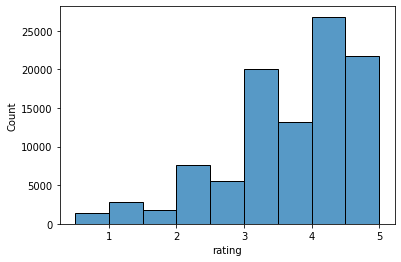

In [6]:
sns.histplot(data=ratings, x="rating", binwidth=0.5)

#### Ratings frequency of movies

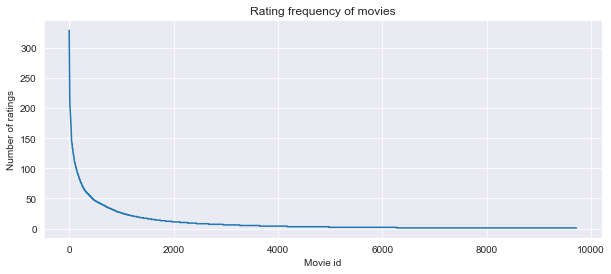

In [120]:
df = df_ratings[['movieId','userId']].groupby(['movieId']).agg(['count']).sort_values(('userId','count'),ascending=False)
 
plt.figure(figsize=(10,4))
sns.set_style("darkgrid")
sns.lineplot(data=df[('userId', 'count')].values)
plt.title("Rating frequency of movies")
plt.xlabel("Movie id")
plt.ylabel("Number of ratings");

#### Ratings frequency of users

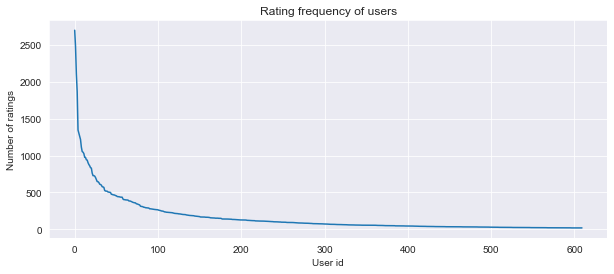

In [125]:
df = df_ratings[['movieId','userId']].groupby(['userId']).agg(['count']).sort_values(('movieId','count'),ascending=False)
 
plt.figure(figsize=(10,4))
sns.set_style("darkgrid")
sns.lineplot(data=df[('movieId', 'count')].values)
plt.title("Rating frequency of users")
plt.xlabel("User id")
plt.ylabel("Number of ratings");

#### User-Item interaction matrix
For top 15th rated users and items for vizualisation

In [7]:
top = 15
g = ratings.groupby('userId')['rating'].count()
topg = g.sort_values(ascending = False)[:top]

i = ratings.groupby('movieId')['rating'].count()
topi = i.sort_values(ascending = False)[:top]

# gettings ratings of top users and top items
join_top_users = ratings.join(topg, on='userId', how = 'inner', rsuffix='_r')
join_top_movies_and_users = join_top_users.join(topi, on='movieId', how = 'inner', rsuffix = '_r')

pd.crosstab(join_top_movies_and_users.userId, join_top_movies_and_users.movieId,
            join_top_movies_and_users.rating, aggfunc=np.mean)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


#### Sparsity

In [73]:
unique_movies = len(ratings["movieId"].unique())
unique_users = len(ratings["userId"].unique())
total_ratings = unique_users * unique_movies
rating_present = ratings.shape[0]

ratings_not_provided = total_ratings - rating_present 

print("sparsity of user-item matrix is :")
print(ratings_not_provided / total_ratings)

sparsity of user-item matrix is :
0.9830003169443864


#### Users-items top 500 users, top 3000 movies
This is done to limit matrix sparsity (for collaborative filtering)

In [105]:
top_users = 500
g = ratings.groupby('userId')['rating'].count()
topg = g.sort_values(ascending = False)[:top_users]

top_movies = 1000
i = ratings.groupby('movieId')['rating'].count()
topi = i.sort_values(ascending = False)[:top_movies]

# gettings ratings of top users and top items
join_top_users = ratings.join(topg, on='userId', how = 'inner', rsuffix='_r')
join_top_movies_and_users = join_top_users.join(topi, on='movieId', how = 'inner', rsuffix = '_r')

user_movie_matrix = pd.crosstab(join_top_movies_and_users.userId, join_top_movies_and_users.movieId,
                                join_top_movies_and_users.rating, aggfunc=np.mean)

In [106]:
user_movie_matrix.iloc[0:5]

movieId,1,2,3,5,6,7,10,11,16,17,...,122892,122900,122904,122918,134130,134853,139385,148626,152081,166528
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,5.0,4.0,4.0,3.0,4.0,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
user_movie_matrix.isna().sum().sum() / float(len(user_movie_matrix) * len(user_movie_matrix.columns))

0.881618

## 2. Collaborative filtering
__Collaborative filtering__ is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past.  
It uses __similarities between users behaviours__ to provide recommendations, there is no need of knowledge/features required.  
There are two types of collaborative filtering:
- __Memory based__
- __Model based__  

The key difference is that we __are not learning any parameter__ using gradient descent (or any other optimization algorithm) in the memory-based.

### 2.1. Matrix Factorization (Model based)
__Matrix Factorization__ is denoted as methods that decompose a rating matrix for collaborative filtering.  
The __user-item interaction matrice__ lists __users and items in rows and columns__, respectively.  
The __ratings of user i on movie j__ is located in __cell(i, j)__ (the cell is empty if no ratings exist yet).  
Documentation: https://developers.google.com/machine-learning/recommendation/collaborative/matrix  
Matrix factorization from scratch: https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b  
Scikit-surprise doc: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

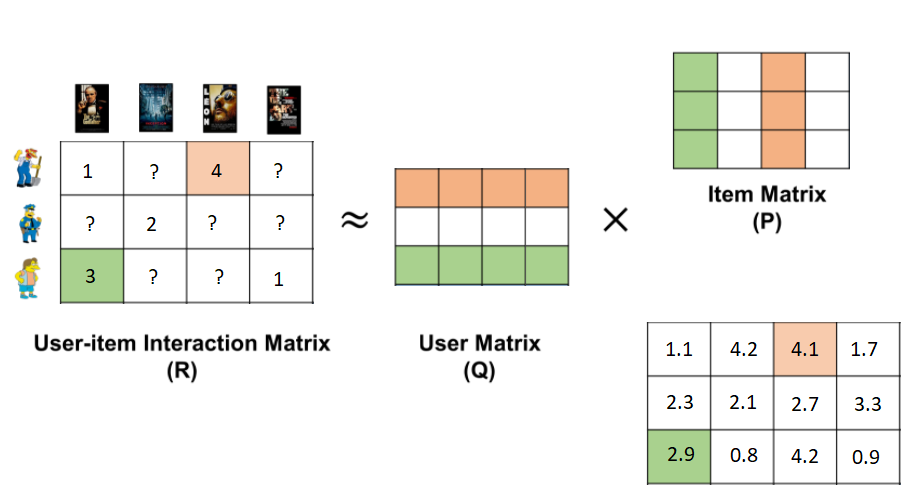

In [92]:
Image(filename='../input_data/matrix_facto_illustration.png')

#### Datapreparation

In [93]:
df_ratings = ratings[['movieId', 'userId', 'rating']]

# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0.5, 5.0))

# The columns must correspond to userId, itemId and ratings (in that order).
dataset_ratings = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)

# Split dataset between train and test set
train, test = train_test_split(dataset_ratings, test_size=.20, random_state=2)
# As if we remove some cells of the user-item matrix to put them in the set

#### NMF: Non-negative Matrix Factorization
Documentation: https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

In [94]:
# Number of latents factors
n_factors=15

# NMF model
nmf = NMF(n_factors=n_factors)

# Train the algorithm on the train set, and predict ratings for the test set
nmf.fit(train)
preds = nmf.test(test)

# Then compute RMSE
accuracy.rmse(preds)

# To dataframe
df_preds = pd.DataFrame(preds)

RMSE: 0.9258


In [95]:
df_preds.iloc[:5]

,uid,iid,r_ui,est,details
0,596,122900,3.5,3.505346,{'was_impossible': False}
1,395,355,3.0,2.397870,{'was_impossible': False}
2,125,48516,4.0,4.437703,{'was_impossible': False}
3,186,3114,4.0,4.238931,{'was_impossible': False}
4,517,1954,0.5,2.290126,{'was_impossible': False}


#### Make a prediction on a user and movie

In [96]:
uid = 517  # raw user id (as in the ratings file)
iid = 1230  # raw item id (as in the ratings file)

# get a prediction for specific users and items.
pred = nmf.predict(uid, iid, verbose=True)  # we can also pass the real value if it is filled

user: 517        item: 1230       r_ui = None   est = 2.51   {'was_impossible': False}


In [97]:
pred = nmf.predict(uid, iid, r_ui=1.5, verbose=True) 

user: 517        item: 1230       r_ui = 1.50   est = 2.51   {'was_impossible': False}


In [98]:
# Let's take a look at the matrices
users_matrix = nmf.pu
print(f'Shape users matrix: {users_matrix.shape},\
    nb users: {users_matrix.shape[0]}, nb latent factors: {users_matrix.shape[1]}')

movies_matrix = nmf.qi
print(f'Shape movies matrix: {movies_matrix.shape},\
    nb movies: {movies_matrix.shape[0]}, nb latent factors: {movies_matrix.shape[1]}')

Shape users matrix: (610, 15),    nb users: 610, nb latent factors: 15
Shape movies matrix: (8994, 15),    nb movies: 8994, nb latent factors: 15


#### First conclusion:
- The mean error (RMSE): 0.9166, which seems pretty correct
- But how to choose the number of factors ? => Using a grid-search on cross-validation

#### Hyperparameter tuning

In [99]:
# Use movielens-100K
nmf = NMF()
param_grid = {'n_factors': [14, 15, 16]}
gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)

gs_nmf.fit(dataset_ratings)

# best RMSE score
print(gs_nmf.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs_nmf.best_params['rmse'])

0.9330244559563917
{'n_factors': 16}


#### SVD: Singular Value Decomposition

In [100]:
# SVD model
svd = SVD()

# Train the algorithm on the train set, and predict ratings for the test set
svd.fit(train)
preds_svd = svd.test(test)

# Then compute RMSE
accuracy.rmse(preds_svd)

# To dataframe
df_preds_svd = pd.DataFrame(preds_svd)

RMSE: 0.8778


### 2.2. k Nearest Neighbour
__K-nearest neighbor__ finds the k most similar items to a particular instance based on a given distance metric.  
It can be used for classification (voting of the k-nearest neighbors) or regression (average values of the k-nearest neighbors).  
In this my model, I used to __cosine similarity__ as metric.

In [143]:
n_neighbors = 20
metric = 'cosine'
model_knn = NearestNeighbors(metric=metric, n_neighbors=n_neighbors, n_jobs=-1)
index_user_to_predict_k_movies = 0
top_k_movies = 5

In [144]:
# Fill nan values in empyt scores as it will not be used in cosine similarity
user_movie_matrix_filled = user_movie_matrix.fillna(0)

# train knn
model_knn.fit(user_movie_matrix_filled)

# Get similar users distances and indexes
user_to_predict_k_movies = user_movie_matrix_filled.iloc[index_user_to_predict_k_movies,:].values.reshape(1,-1)
distances, indices_similar_users = model_knn.kneighbors(user_to_predict_k_movies)
distances = distances.flatten()
indices_similar_users = indices_similar_users.flatten()

In [153]:
# Taking average scores for these users (excluding zero because no score)
similar_users = user_movie_matrix[user_movie_matrix.index.isin(indices_similar_users)]
movies_scores_similar_users = np.nanmean(similar_users, axis=0)
movies_scores_similar_users = np.nan_to_num(movies_scores_similar_users)

C:\Users\NICOLA~1.CLA\AppData\Local\Temp/ipykernel_11028/3966471157.py:3: RuntimeWarning: Mean of empty slice
  movies_scores_similar_users = np.nanmean(similar_users, axis=0)


In [158]:
top_movies = []

while len(top_movies) <= top_k_movies:
    # Get index of the movie with the max score
    max_value_index = movies_scores_similar_users.argmax()
    
    # Adding the movie with the highest score to the top list
    top_movies.append(max_value_index)
    
    # Removing this index in the movies
    movies_scores_similar_users = np.delete(movies_scores_similar_users, max_value_index)

In [160]:
top_movies
# there is still the need to remove movies that the user 0 have already watched, we can integrate it in the whil loop upper.

[61, 159, 168, 185, 186, 210]

#### Pros
- __No domain knowledge necessary__: It does not need any information regarding the movies (genres, author...) , and any "understanding" of the movie itself 
- __Serendipity__ : The user can __discover new interests__

#### Cons
- __Cold start__: For a new user or item, there isn't enough data to make accurate recommendations. 
- __Scalability__: There are millions of users and products in many of the environments in which these systems make recommendations. Thus, a large amount of computation power is often necessary to calculate recommendations.
- __Sparsity__: The number of items sold on major e-commerce sites is extremely large. The most active users will only have rated a small subset of the overall database. Thus, even the most popular items have very few ratings.

## 3. Content-based Filtering
__Content-Based Filtering__ is used to produce items recommendation based on items’ and/or users characteristics.  
In these types of systems, the __descriptive attributes of items/users are used__ to make recommendations. The term “content” refers to these descriptions.

In [195]:
movies.iloc[20:40]

,movieId,title,genres
20,21,Get Shorty (1995),Comedy Crime Thriller
21,22,Copycat (1995),Crime Drama Horror Mystery Thriller
22,23,Assassins (1995),Action Crime Thriller
23,24,Powder (1995),Drama Sci-Fi
24,25,Leaving Las Vegas (1995),Drama Romance
25,26,Othello (1995),Drama
26,27,Now and Then (1995),Children Drama
27,28,Persuasion (1995),Drama Romance
28,29,"City of Lost Children, The (Cité des enfants p...",Adventure Drama Fantasy Mystery Sci-Fi
29,30,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,Crime Drama


#### tf-idf

We need to __convert the word vector__ into a __numerical representation__ We will use __Term Frequency-Inverse Document Frequency (TF-IDF)__ vectors for each overview.

It is the __relative frequency of a word in a document__ and is given as (term instances/total instances). Inverse Document Frequency is the relative count of documents containing the term, given as log(number of documents/documents with term) The overall importance of each word to the documents in which they appear is equal to TF * IDF

In [202]:
tfidf = TfidfVectorizer(stop_words='english')
movies['genres'] = movies['genres'].apply(lambda x: x.replace('|', ' ').replace('-', ''))

# tfidf matrix
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [204]:
tfidf_matrix.shape

(9742, 21)

(9742, 21)  means that here are 21 different words are used to describe a 9742 movies.

In [205]:
tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'filmnoir', 'genres', 'horror',
       'imax', 'listed', 'musical', 'mystery', 'romance', 'scifi',
       'thriller', 'war', 'western'], dtype=object)

In [180]:
len(tfidf.get_feature_names_out())

23

In [210]:
# Compute cosine similarity
cosin_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Put it in a Pandas Series
index_of_movies = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [221]:
def get_recommendations(title, cosin_sim=cosin_sim, top_k=10):
    
    idx_of_title = index_of_movies[title]
    
    similarity_scores = list(enumerate(cosin_sim[idx_of_title]))
    
    # sorting of movies idx based on similarity score
    similarity_scores = sorted(similarity_scores, key = lambda x:x[1], reverse = True)
    
    # get top k
    similarity_scores = similarity_scores[0:top_k]
    movies_idx = [i[0] for i in similarity_scores]
    
    return movies.iloc[movies_idx]

#### Make recommendation

In [222]:
get_recommendations(title='Dangerous Minds (1995)', cosin_sim=cosin_sim)

,movieId,title,genres
13,14,Nixon (1995),Drama
25,26,Othello (1995),Drama
30,31,Dangerous Minds (1995),Drama
36,40,"Cry, the Beloved Country (1995)",Drama
39,43,Restoration (1995),Drama
50,55,Georgia (1995),Drama
51,57,Home for the Holidays (1995),Drama
55,62,Mr. Holland's Opus (1995),Drama
105,121,"Boys of St. Vincent, The (1992)",Drama
120,147,"Basketball Diaries, The (1995)",Drama


This is not very efficient as all the movies with the same genre would have the same similarity score...  
Let's try with another dataset with more information.

#### Content-based filtering based on movie overview description
https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv

In [234]:
movies_lmdb = pd.read_csv('../input_data/tmdb_5000_movies.csv')
print('Nb of rows of movies lmdb:')
print(len(movies_lmdb))

Nb of rows of movies lmdb:
4803


In [227]:
movies_lmdb.iloc[0:3]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


Let's perform a content-based filtering on the overview informations (brief description of the movie)

In [235]:
movies_lmdb['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [238]:
tfidf = TfidfVectorizer(stop_words='english')

# Replace NaN with an empty string
movies_lmdb['overview'] = movies_lmdb['overview'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies_lmdb['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

print(f'Nb of movies: {tfidf_matrix.shape[0]}  Nb of text features: {tfidf_matrix.shape[1]}')

Nb of movies: 4803  Nb of text features: 20978


In [239]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [240]:
# Pandas series
indices = pd.Series(movies_lmdb.index, index=movies_lmdb['title']).drop_duplicates()

In [241]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim, top_k_movies=10):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top k similar movies
    sim_scores = sim_scores[1:(top_k_movies+1)]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_lmdb['title'].iloc[movie_indices]

In [242]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

In [244]:
get_recommendations('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object